In [1]:
import os
import json
import numpy as np
from scipy.stats import kendalltau
from scipy.spatial import ConvexHull
from scipy.spatial.qhull import QhullError
from scipy.spatial.distance import cdist, pdist
from operator import itemgetter
from itertools import chain
from src.lexrank import degree_centrality_scores

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import ray

from config import *

In [2]:
DATASET = DATASETS[1]
DATA_DIR = f'/scratch/korunosk/data/{DATASET}'

In [3]:
ray.init(num_cpus=40)

2020-03-03 18:13:44,877	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-03 18:13:44,884	INFO resource_spec.py:212 -- Starting Ray with 34.57 GiB memory available for workers and up to 17.29 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-03 18:13:45,282	INFO services.py:1078 -- View the Ray dashboard at localhost:8266


{'node_ip_address': '10.90.36.41',
 'redis_address': '10.90.36.41:29620',
 'object_store_address': '/tmp/ray/session_2020-03-03_18-13-44_876606_42571/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-03_18-13-44_876606_42571/sockets/raylet',
 'webui_url': 'localhost:8266',
 'session_dir': '/tmp/ray/session_2020-03-03_18-13-44_876606_42571'}

In [10]:
@ray.remote
def load_and_extract(t):
    with open(os.path.join(DATA_DIR, t + '_encoded.json'), mode='r') as fp:
        topic = json.load(fp)
    
    documents = np.array(list(chain(*topic['documents'])))
    annotations = topic['annotations']

    summaries_tmp = list(map(itemgetter('text'), annotations))
    indices_tmp = np.cumsum([0] + list(map(len, summaries_tmp)))
    summaries = np.array(list(chain(*summaries_tmp)))
    indices = np.array(list(zip(indices_tmp[:-1], indices_tmp[1:])))
    
    pyr_scores = np.array(list(map(itemgetter('pyr_score'), annotations)))
    
    return documents, summaries, indices, pyr_scores


@ray.remote
def experiment_average_pairwise_distance(data):
    document_embs, summary_embs, indices, pyr_scores = data
    
    def average_pairwise_distance(summary_embs: np.array) -> float:
        '''Calculates the average pairwise distance between summary embeddings'''
        return np.mean(cdist(summary_embs, summary_embs, metric='euclidean'))
    
    metric = lambda i: average_pairwise_distance(summary_embs[i[0]:i[1]])
    
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

@ray.remote
def experiment_semantic_volume(data):
    document_embs, summary_embs, indices, pyr_scores = data
    
    embs = np.concatenate((document_embs, summary_embs))
    t = document_embs.shape[0]
    pca = PCA(n_components=2, random_state=42)
    pts = pca.fit_transform(embs)
    document_pts, summary_pts = pts[:t], pts[t:]
    
    def semantic_volume(summary_embs: np.array) -> float:
        '''Calculates the semantic volume of the summary embeddings'''
        try:
            return ConvexHull(summary_embs).volume
        except QhullError as e:
            return 0
    
    metric = lambda i: semantic_volume(summary_pts[i[0]:i[1]])
    
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

@ray.remote
def experiment_semantic_spread(data):
    document_embs, summary_embs, indices, pyr_scores = data

    def semantic_spread(summary_embs: np.array) -> float:
        '''Calculates the semantic spread of the summary embeddings'''
        return np.linalg.det(summary_embs @ summary_embs.T)

    metric = lambda i: semantic_spread(summary_embs[i[0]:i[1]])
    
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]


def execute_experiment(experiment):
    data   = [ load_and_extract.remote(t) for t in TOPICS[DATASET] ]
    scores = [ experiment.remote(d) for d in data ]

    return np.array(ray.get(scores))

scores = execute_experiment(experiment_semantic_spread)

print(np.mean(scores))

0.12921594645067994


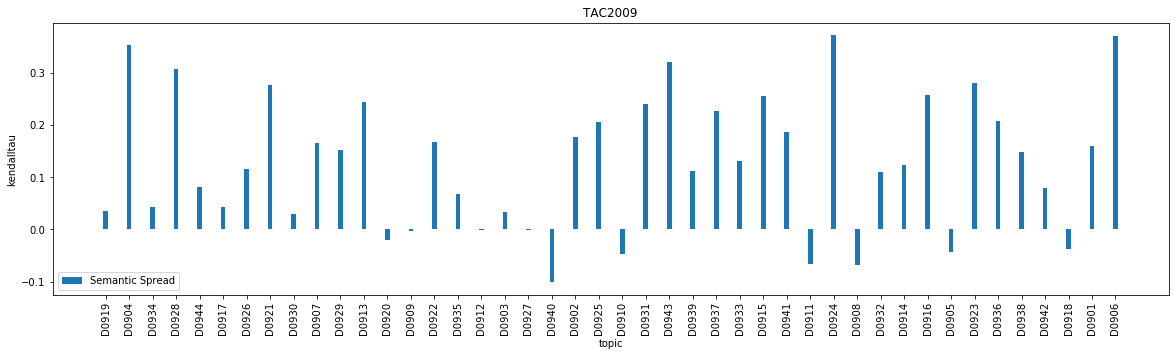

In [11]:
x = np.arange(len(TOPICS[DATASET]))

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
ax.bar(x, scores, width=0.2, label='Semantic Spread')
ax.set_xticks(x)
ax.set_xticklabels(TOPICS[DATASET], rotation=90)
ax.set_title(DATASET)
ax.set_xlabel('topic')
ax.set_ylabel('kendalltau')
ax.legend()
plt.show()